In [3]:
import numpy as np
import triangle
import matplotlib.pyplot as plt
import pandas as pd
from scipy.sparse import lil_matrix, bmat
from scipy.sparse.linalg import spsolve
from scipy.spatial import Delaunay




In [5]:
def compute_B(coords):
    (x1,y1),(x2,y2),(x3,y3) = coords
    area = 0.5 * np.linalg.det([[1,x1,y1],[1,x2,y2],[1,x3,y3]])
    b = np.array([y2-y3, y3-y1, y1-y2]) / (2*area)
    c = np.array([x3-x2, x1-x3, x2-x1]) / (2*area)
    B = np.zeros((3,6))
    for i in range(3):
        B[0,2*i]   = b[i]
        B[1,2*i+1] = c[i]
        B[2,2*i]   = c[i]
        B[2,2*i+1] = b[i]
    return B, area

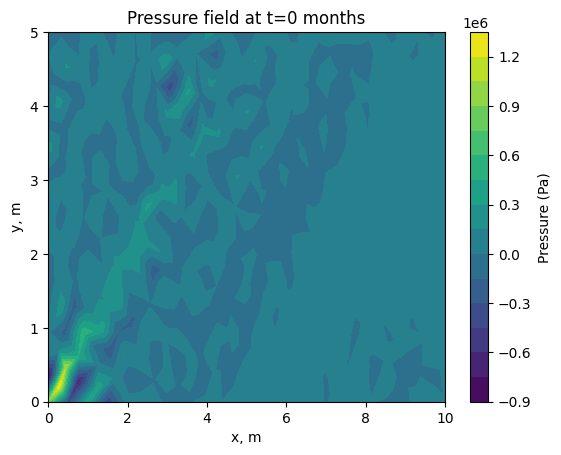

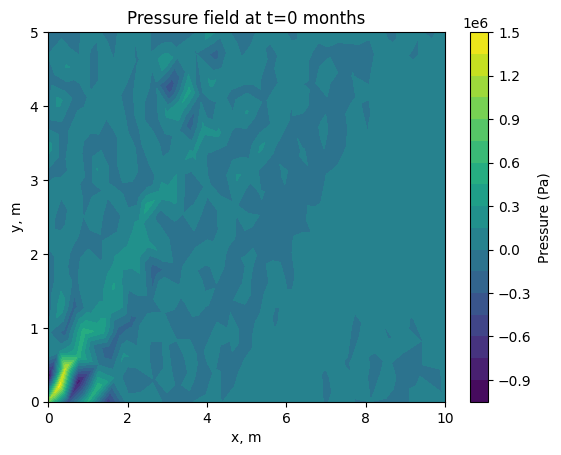

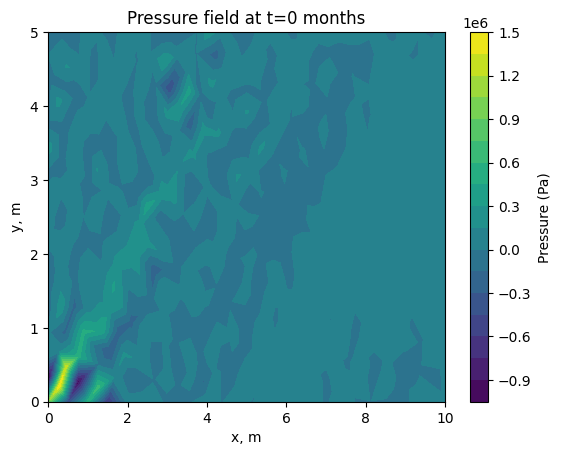

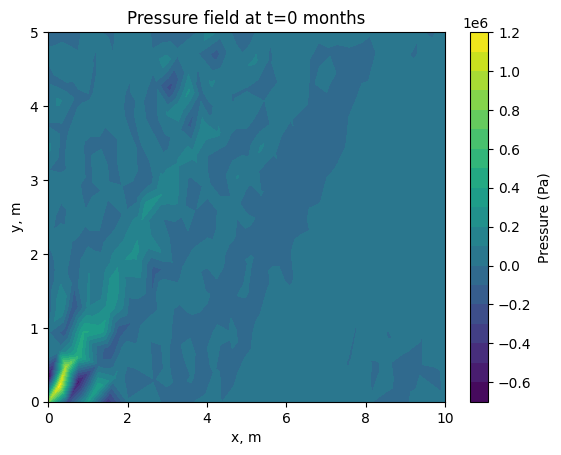

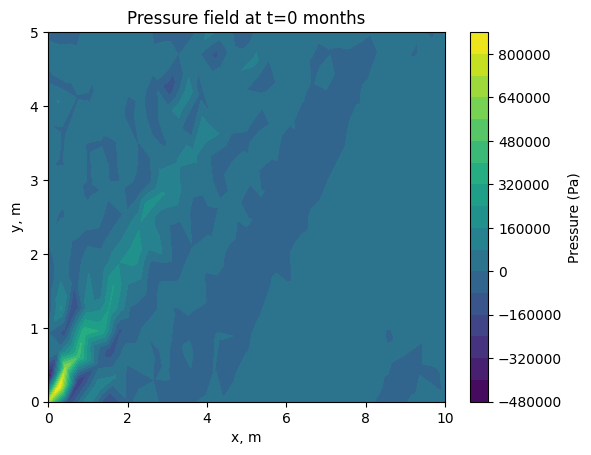

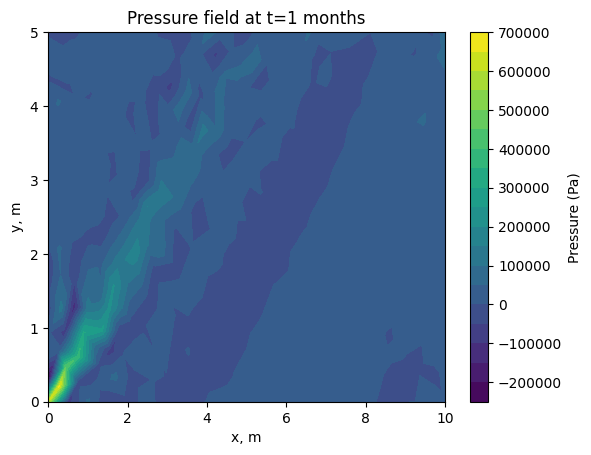

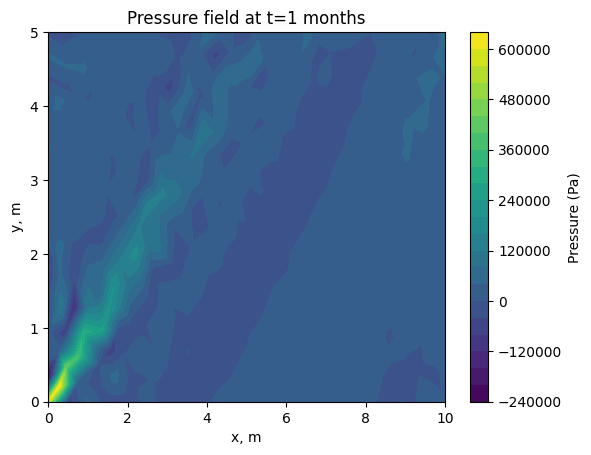

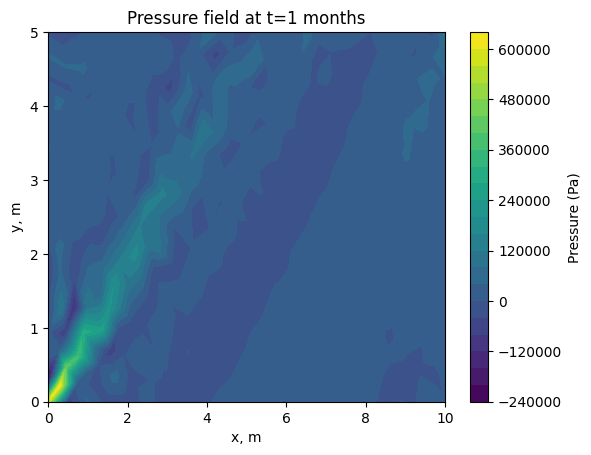

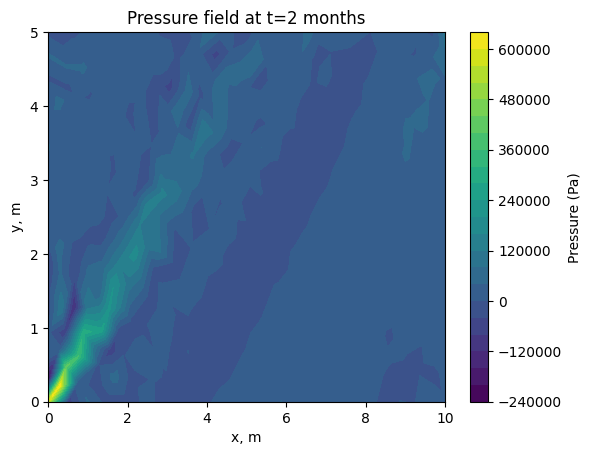

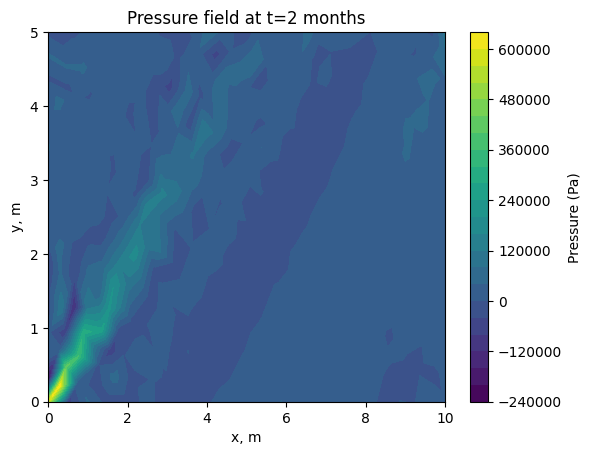

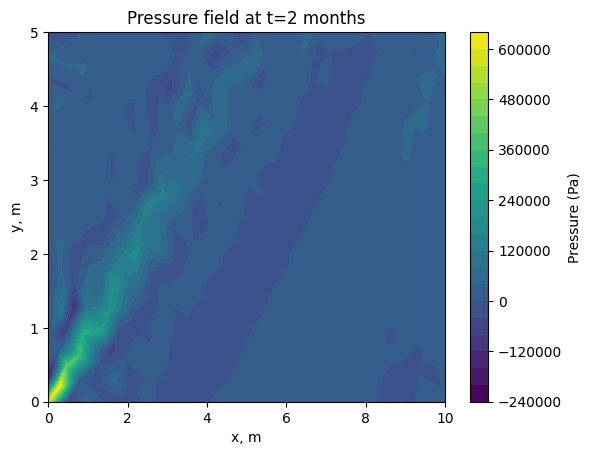

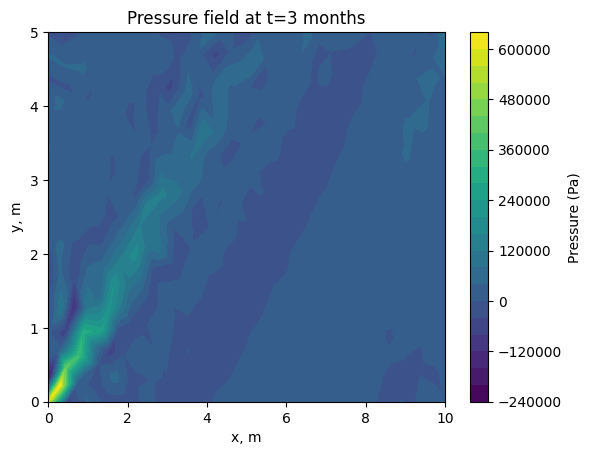

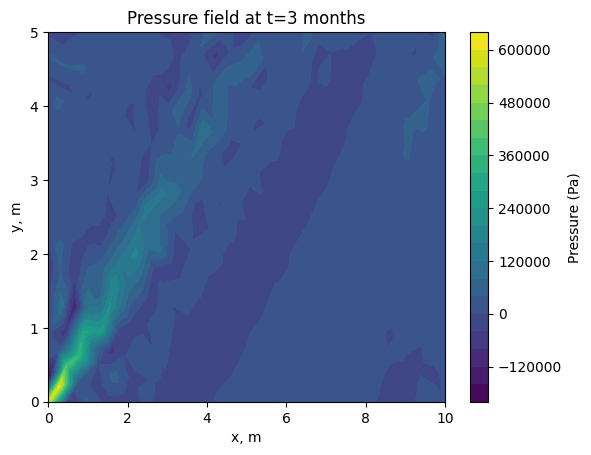

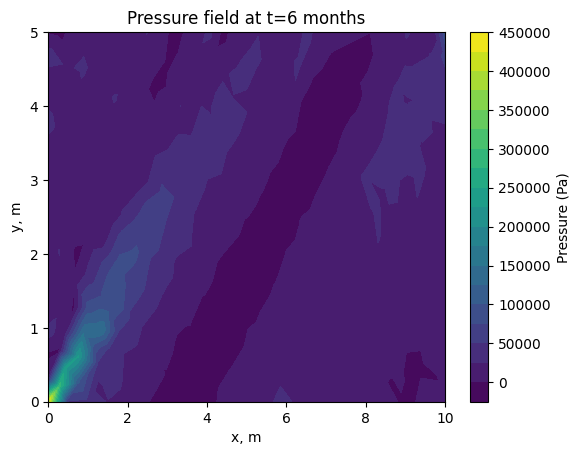

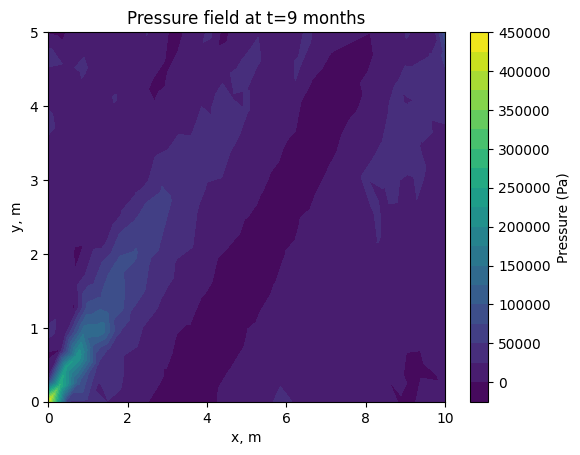

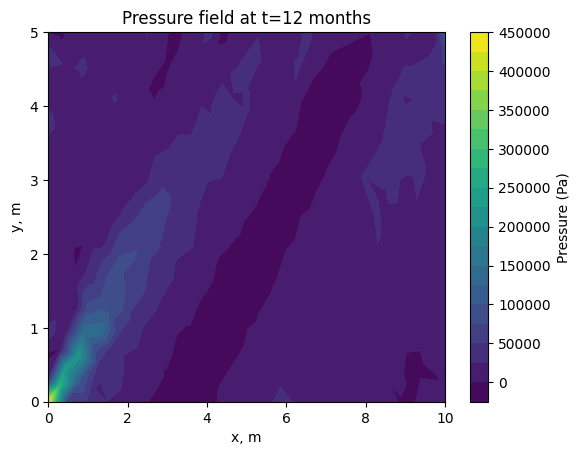

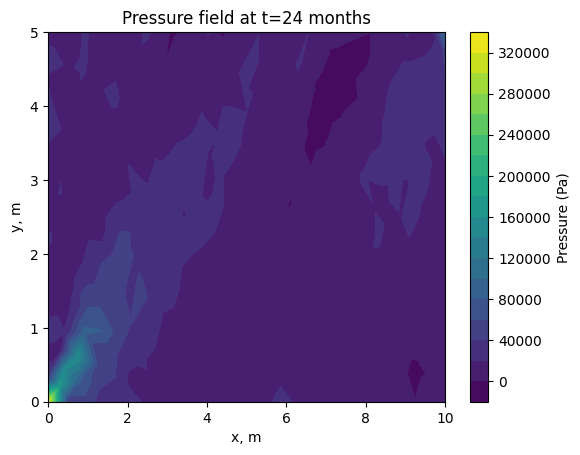

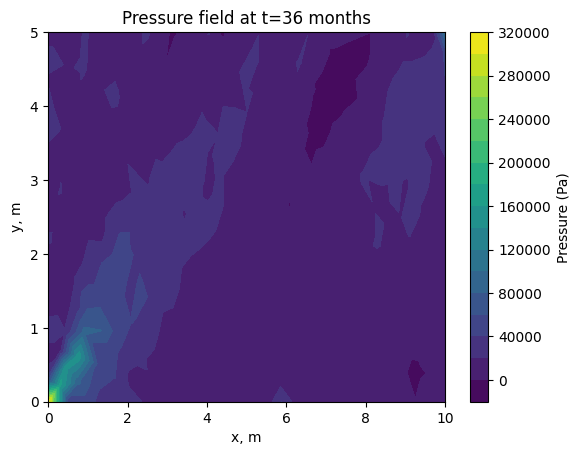

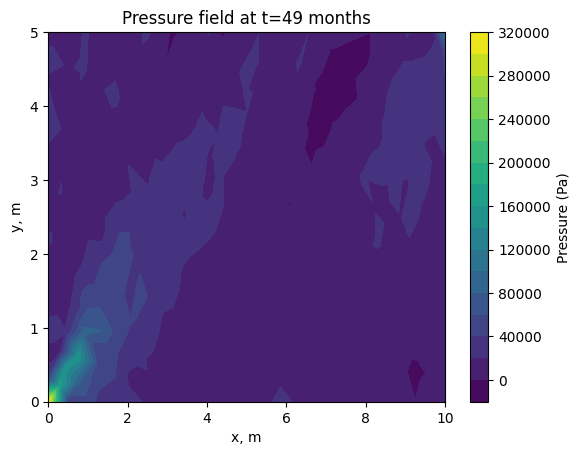

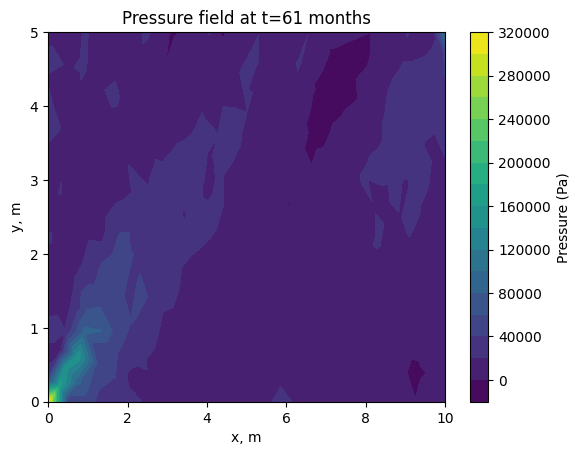

    Time (months)  Max Settlement (m)
0               0           -0.584979
1               0           -0.583588
2               0           -0.583101
3               0           -0.588027
4               0           -0.591503
5               1           -0.595323
6               1           -0.595644
7               1           -0.595677
8               2           -0.595681
9               2           -0.595682
10              2           -0.595682
11              3           -0.595682
12              3           -0.596140
13              6           -0.609100
14              9           -0.609345
15             12           -0.609436
16             24           -0.622931
17             36           -0.623022
18             49           -0.623023
19             61           -0.623023


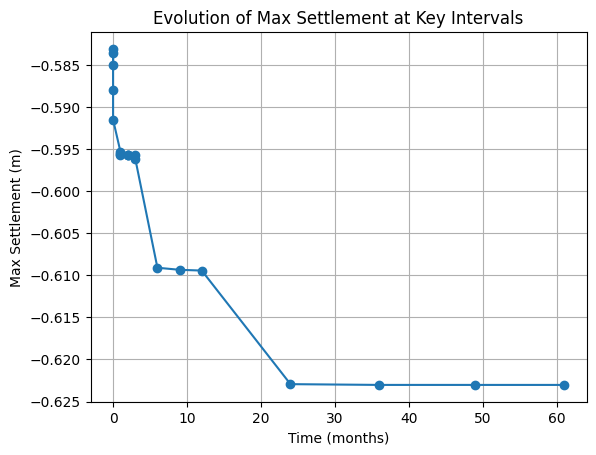

In [ ]:

# --------------------------------------------------
# 1. Фізичні параметри та домен
# --------------------------------------------------
phi, E, nu = 0.6, 1e6, 0.3
kappa, mu = 1e-13, 1e-3
alpha, S, rho = 0.9, 5e-9, 2000
Lx, Ly = 10.0, 5.0

# --------------------------------------------------
# 2. Генерація сітки через triangle
# --------------------------------------------------
points = np.array([[0,0],[Lx,0],[Lx,Ly],[0,Ly]])
segments = [[0,1],[1,2],[2,3],[3,0]]
mesh = triangle.triangulate({'vertices': points, 'segments': segments}, 'pq30a0.1')
verts     = mesh['vertices']
triangles = mesh['triangles']
num_nodes = verts.shape[0]
num_elems = triangles.shape[0]

# --------------------------------------------------
# 3. Матриця пружності (Plane Strain)
# --------------------------------------------------
lam = E*nu/((1+nu)*(1-2*nu))
G   = E/(2*(1+nu))
C = np.array([[lam+2*G, lam,      0],
              [lam,     lam+2*G,  0],
              [0,       0,        G]])

# --------------------------------------------------
# 4. Локальна матриця B та площа елемента
# --------------------------------------------------


# --------------------------------------------------
# 5. Збирання глобальних матриць K, Q, H, M
# --------------------------------------------------
ndof_u = 2 * num_nodes
ndof_p = num_nodes

K = lil_matrix((ndof_u,ndof_u))
Q = lil_matrix((ndof_u,ndof_p))
H = lil_matrix((ndof_p,ndof_p))
M = lil_matrix((ndof_p,ndof_p))

for el in range(num_elems):
    idx    = triangles[el]
    coords = verts[idx]
    B, area= compute_B(coords)
    Ke     = (B.T @ C @ B) * area
    He     = (kappa/mu) * (B[:2].T @ B[:2]) * area
    Me     =  S * (area/12) * (np.ones((3,3)) + np.eye(3))
    dof_u  = np.array([[2*i,2*i+1] for i in idx]).ravel()
    for i in range(6):
        for j in range(6):
            K[dof_u[i],dof_u[j]] += Ke[i,j]
    for i in range(6):
        for j in range(3):
            Q[dof_u[i],idx[j]] += alpha * B[:,i].sum() * area/3
    for i in range(3):
        for j in range(3):
            H[idx[i],idx[j]] += He[i,j]
            M[idx[i],idx[j]] += Me[i,j]

K = K.tocsr(); Q = Q.tocsr(); H = H.tocsr(); M = M.tocsr()

# --------------------------------------------------
# 6. Граничні умови (завантаження)
# --------------------------------------------------
bdy_u    = np.where(np.isclose(verts[:,1],0))[0]
fixed_u  = np.hstack([2*bdy_u,2*bdy_u+1])
free_u   = np.setdiff1d(np.arange(ndof_u), fixed_u)
free_p   = np.arange(ndof_p)

top_nodes= np.where(np.isclose(verts[:,1],Ly))[0]
f_u      = np.zeros(ndof_u)
p_load   = 1e5
for n in top_nodes:
    f_u[2*n+1] = -p_load * (Lx/len(top_nodes))

# --------------------------------------------------
# 7. Цикл завантаження: ключові інтервали (дні)
# --------------------------------------------------
times = [0, 1, 2, 5, 10, 20, 30, 40, 50, 60,70, 80,  91, 182, 273, 365, 730, 1095, 1460, 1825 ]  # 0, 1, 2 ,3,6,9,12,24,36,48,60 міс

p_prev = np.full(ndof_p, 1e5)
results_u = {}
results_p = {}

prev_t = 0
for t in times:
    dt     = t - prev_t
    A_full = bmat([[K, -Q],
                   [Q.T, M + dt*H]], format='csr')
    rhs    = np.hstack([f_u, M.dot(p_prev)])
    idxs   = np.hstack([free_u, ndof_u+free_p])
    sol    = spsolve(A_full[idxs][:,idxs], rhs[idxs])
    u      = np.zeros(ndof_u)
    u[free_u] = sol[:len(free_u)]
    p      = np.zeros(ndof_p)
    p[:]   = sol[len(free_u):]
    p_prev = p.copy()
    results_u[t] = u
    results_p[t] = p
    prev_t = t

# --------------------------------------------------
# 8. Графіки поля тиску для кожного часу
# --------------------------------------------------
for t in times:
    p = results_p[t]
    plt.figure()
    plt.tricontourf(verts[:,0], verts[:,1], triangles, p, levels=20)
    plt.colorbar(label='Pressure (Pa)')
    plt.title(f'Pressure field at t={round(t/30)} months')
    plt.xlabel('x, m'); plt.ylabel('y, m')
plt.show()

# --------------------------------------------------
# 9. Обчислення та графік осадки (Max Settlement)
# --------------------------------------------------
metrics = []
for t in times:
    u               = results_u[t]
    uy              = u[1::2]
    max_sett        = uy.min()
    metrics.append({"Time (months)": round(t/30),
                    "Max Settlement (m)": max_sett})

df = pd.DataFrame(metrics)
print(df)

plt.figure()
plt.plot(df["Time (months)"], df["Max Settlement (m)"], marker='o')
plt.xlabel("Time (months)")
plt.ylabel("Max Settlement (m)")
plt.title("Evolution of Max Settlement at Key Intervals")
plt.grid(True)
plt.show()


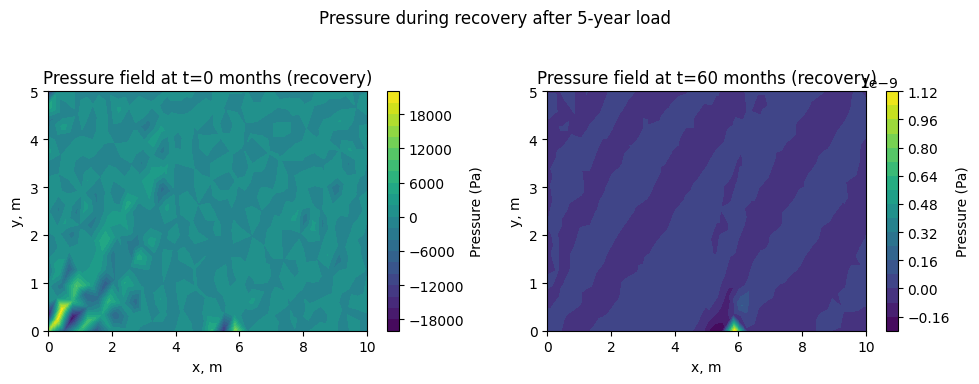

 Month  Max Settlement (m)
     0       -3.107878e-04
     1       -1.057826e-05
     2       -7.493133e-07
     3       -4.859812e-08
     6       -2.070222e-09
    12       -5.081734e-11
    24       -1.101300e-12
    36       -2.345388e-14
    48       -4.657081e-16
    60       -9.063061e-18


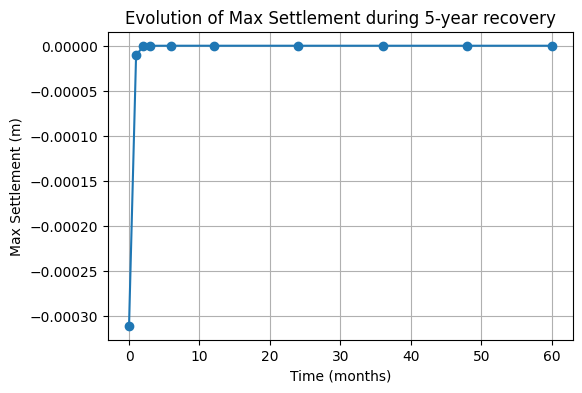

In [11]:

phi, E, nu = 0.6, 1e6, 0.3
kappa, mu = 1e-13, 1e-3
alpha, S, rho = 0.9, 5e-9, 2000
Lx, Ly = 10.0, 5.0

points   = np.array([[0,0],[Lx,0],[Lx,Ly],[0,Ly]])
segments = [[0,1],[1,2],[2,3],[3,0]]
mesh     = triangle.triangulate({'vertices': points, 'segments': segments}, 'pq30a0.1')
verts    = mesh['vertices']
triangles= mesh['triangles']
num_nodes= verts.shape[0]
num_elems= triangles.shape[0]

lam = E*nu/((1+nu)*(1-2*nu))
G   = E/(2*(1+nu))
C   = np.array([[lam+2*G, lam, 0],
                [lam, lam+2*G, 0],
                [0,   0,       G]])

def compute_B(coords):
    (x1,y1),(x2,y2),(x3,y3) = coords
    area = 0.5*np.linalg.det([[1,x1,y1],[1,x2,y2],[1,x3,y3]])
    b = np.array([y2-y3, y3-y1, y1-y2])/(2*area)
    c = np.array([x3-x2, x1-x3, x2-x1])/(2*area)
    B = np.zeros((3,6))
    for i in range(3):
        B[0,2*i]   = b[i]
        B[1,2*i+1] = c[i]
        B[2,2*i]   = c[i]
        B[2,2*i+1] = b[i]
    return B, area

ndof_u = 2 * num_nodes
ndof_p = num_nodes

K = lil_matrix((ndof_u, ndof_u))
Q = lil_matrix((ndof_u, ndof_p))
H = lil_matrix((ndof_p, ndof_p))
M = lil_matrix((ndof_p, ndof_p))

for el in range(num_elems):
    idx    = triangles[el]
    coords = verts[idx]
    B, area= compute_B(coords)
    Ke     = (B.T @ C @ B) * area
    He     = (kappa/mu) * (B[:2].T @ B[:2]) * area
    Me     =  S * (area/12) * (np.ones((3,3)) + np.eye(3))
    dof_u  = np.array([[2*i,2*i+1] for i in idx]).ravel()

    for i in range(6):
        for j in range(6):
            K[dof_u[i],dof_u[j]] += Ke[i,j]
    for i in range(6):
        for j in range(3):
            Q[dof_u[i],idx[j]] += alpha * B[:,i].sum() * area/3
    for i in range(3):
        for j in range(3):
            H[idx[i],idx[j]] += He[i,j]
            M[idx[i],idx[j]] += Me[i,j]

K = K.tocsr(); Q = Q.tocsr(); H = H.tocsr(); M = M.tocsr()


bdy_u    = np.where(np.isclose(verts[:,1], 0))[0]
fixed_u  = np.hstack([2*bdy_u, 2*bdy_u+1])
free_u   = np.setdiff1d(np.arange(ndof_u), fixed_u)
free_p   = np.arange(ndof_p)

top_nodes = np.where(np.isclose(verts[:,1], Ly))[0]
f_u       = np.zeros(ndof_u)
p_load    = 1e5
for n in top_nodes:
    f_u[2*n+1] = -p_load * (Lx/len(top_nodes))

times = [0, 30, 60, 90, 180, 365, 730, 1095, 1460, 1825]

p_prev      = np.full(ndof_p, 1e5)
results_u_L = {}
results_p_L = {}
prev_t      = 0

idxs = np.hstack([free_u, ndof_u + free_p])

for t in times:
    dt     = t - prev_t
    A_full = bmat([[K, -Q],
                   [Q.T, M + dt*H]], format='csr')
    rhs    = np.hstack([f_u, M.dot(p_prev)])
    sol    = spsolve(A_full[idxs][:,idxs], rhs[idxs])

    u = np.zeros(ndof_u)
    u[free_u] = sol[:free_u.size]
    p = np.zeros(ndof_p)
    p[:] = sol[free_u.size:]

    results_u_L[t] = u
    results_p_L[t] = p
    p_prev = p.copy()
    prev_t = t

p_prev_R   = results_p_L[times[-1]].copy()
results_u_R= {times[-1]: results_u_L[times[-1]]}
results_p_R= {times[-1]: results_p_L[times[-1]]}
prev_t     = 0
f_u_zero   = np.zeros(ndof_u)

for t in times:
    dt     = t - prev_t
    A_full = bmat([[K, -Q],
                   [Q.T, M + dt*H]], format='csr')
    rhs    = np.hstack([f_u_zero, M.dot(p_prev_R)])
    sol    = spsolve(A_full[idxs][:,idxs], rhs[idxs])

    u = np.zeros(ndof_u)
    u[free_u] = sol[:free_u.size]
    p = np.zeros(ndof_p)
    p[:] = sol[free_u.size:]

    results_u_R[t] = u
    results_p_R[t] = p
    p_prev_R = p.copy()
    prev_t    = t


import matplotlib.pyplot as plt
import pandas as pd

times = [0, 30, 60, 90, 180, 365, 730, 1095, 1460, 1825]

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
p_rec_0 = results_p_R[0]
plt.tricontourf(verts[:,0], verts[:,1], triangles, p_rec_0, levels=20)
plt.colorbar(label='Pressure (Pa)')
plt.title('Pressure field at t=0 months (recovery)')
plt.xlabel('x, m'); plt.ylabel('y, m')

plt.subplot(1,2,2)
p_rec_60 = results_p_R[1825]
plt.tricontourf(verts[:,0], verts[:,1], triangles, p_rec_60, levels=20)
plt.colorbar(label='Pressure (Pa)')
plt.title('Pressure field at t=60 months (recovery)')
plt.xlabel('x, m'); plt.ylabel('y, m')

plt.suptitle('Pressure during recovery after 5-year load')
plt.tight_layout(rect=[0,0.03,1,0.95])
plt.show()

months = [t//30 for t in times]
max_sett_rec = [results_u_R[t][1::2].min() for t in times]

df_rec = pd.DataFrame({
    'Month': months,
    'Max Settlement (m)': max_sett_rec
})

print(df_rec.to_string(index=False))

plt.figure(figsize=(6,4))
plt.plot(df_rec['Month'], df_rec['Max Settlement (m)'], '-o')
plt.xlabel('Time (months)')
plt.ylabel('Max Settlement (m)')
plt.title('Evolution of Max Settlement during 5-year recovery')
plt.grid(True)
plt.show()


   Year  Max Settlement (m)
0     1           -1.172561
1     2           -1.172168
2     3           -1.172166
3     4           -1.172166
4     5           -1.172166


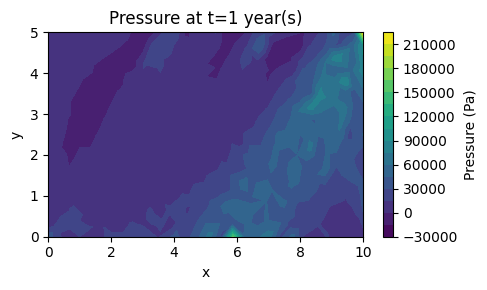

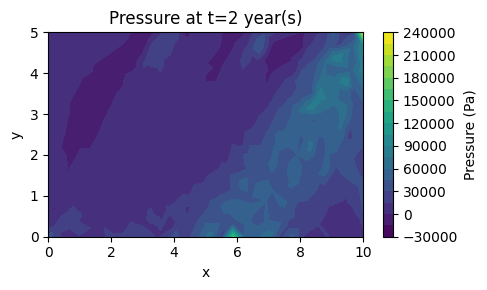

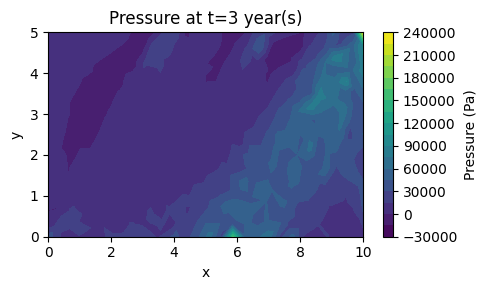

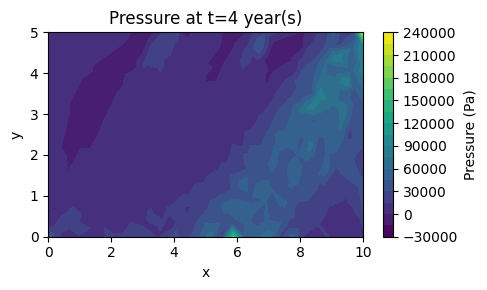

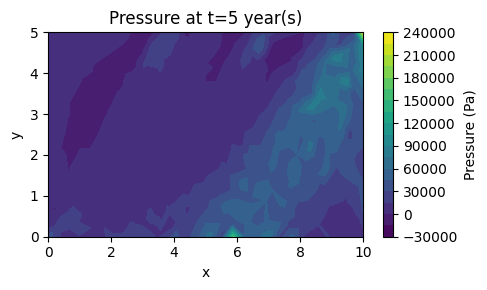

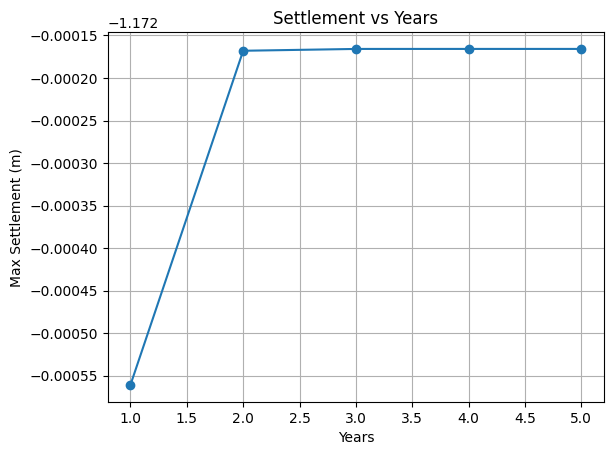

In [20]:

# --------------------------------------------------
# 1. Параметри та сітка
# --------------------------------------------------
phi, E, nu = 0.6, 1e6, 0.3
kappa, mu = 1e-13, 1e-3
alpha, S, rho = 0.9, 5e-9, 2000
Lx, Ly = 10.0, 5.0

points  = np.array([[0,0],[Lx,0],[Lx,Ly],[0,Ly]])
segments= [[0,1],[1,2],[2,3],[3,0]]
mesh    = triangle.triangulate({'vertices': points,'segments':segments}, 'pq30a0.1')
verts   = mesh['vertices']
tris    = mesh['triangles']
num_nodes = verts.shape[0]

# --------------------------------------------------
# 2. Матриця пружності
# --------------------------------------------------
lam = E*nu/((1+nu)*(1-2*nu)); G = E/(2*(1+nu))
C   = np.array([[lam+2*G,lam,0],[lam,lam+2*G,0],[0,0,G]])

ndof_u = 2*num_nodes; ndof_p = num_nodes
K = lil_matrix((ndof_u,ndof_u)); Q = lil_matrix((ndof_u,ndof_p))
H = lil_matrix((ndof_p,ndof_p)); M = lil_matrix((ndof_p,ndof_p))

for el in range(len(tris)):
    idx = tris[el]; coords = verts[idx]
    B, area = compute_B(coords)
    Ke = B.T@C@B*area
    He = (kappa/mu)*(B[:2].T@B[:2])*area
    Me = S*(area/12)*(np.ones((3,3))+np.eye(3))
    dof_u = np.array([[2*i,2*i+1] for i in idx]).ravel()
    for i in range(6):
        for j in range(6):
            K[dof_u[i],dof_u[j]] += Ke[i,j]
    for i in range(6):
        for j in range(3):
            Q[dof_u[i], idx[j]] += alpha * B[:,i].sum() * area/3
    for i in range(3):
        for j in range(3):
            H[idx[i],idx[j]] += He[i,j]
            M[idx[i],idx[j]] += Me[i,j]

K=K.tocsr(); Q=Q.tocsr(); H=H.tocsr(); M=M.tocsr()

# --------------------------------------------------
# 4. Граничні умови (завантаження)
# --------------------------------------------------

bdy_u    = np.where(np.isclose(verts[:,1], 0))[0]
fixed_u  = np.hstack([2*bdy_u,2*bdy_u+1])
free_u   = np.setdiff1d(np.arange(ndof_u), fixed_u)
free_p   = np.arange(ndof_p)

top_nodes = np.where(np.isclose(verts[:,1], Ly))[0]
red_nodes   = top_nodes[verts[top_nodes,0] <  Lx/3]
green_nodes= top_nodes[(verts[top_nodes,0]>=Lx/3)&(verts[top_nodes,0]<2*Lx/3)]
blue_nodes = top_nodes[verts[top_nodes,0]>=2*Lx/3]

pressures = {
    'red':   0.5e5,
    'green': 1.0e5,
    'blue':  2.0e5
}

years = [365*i for i in range(1,6)]

results_u = {}
results_p = {}

for t in years:
    f_u = np.zeros(ndof_u)
    for n in red_nodes:
        f_u[2*n+1] = -pressures['red']*(Lx/3)/len(red_nodes)
    for n in green_nodes:
        f_u[2*n+1] = -pressures['green']*(Lx/3)/len(green_nodes)
    for n in blue_nodes:
        f_u[2*n+1] = -pressures['blue']*(Lx/3)/len(blue_nodes)

    dt = t if t==years[0] else t-years[years.index(t)-1]
    A_full = bmat([[K, -Q],[Q.T, M+dt*H]], format='csr')
    rhs    = np.hstack([f_u, M.dot(results_p.get(years[years.index(t)-1], np.full(ndof_p,1e5)))])
    idxs   = np.hstack([free_u, ndof_u+free_p])
    sol    = spsolve(A_full[idxs][:,idxs], rhs[idxs])

    u = np.zeros(ndof_u); u[free_u]=sol[:len(free_u)]
    p = np.zeros(ndof_p); p[:] = sol[len(free_u):]

    results_u[t]=u; results_p[t]=p
    
for t in years:
    plt.figure(figsize=(5,3))
    plt.tricontourf(verts[:,0],verts[:,1],tris, results_p[t], levels=20)
    plt.colorbar(label='Pressure (Pa)')
    plt.title(f'Pressure at t={t//365} year(s)')
    plt.xlabel('x'); plt.ylabel('y')
    plt.tight_layout()

metrics=[]
for t in years:
    uy = results_u[t][1::2]
    metrics.append({'Year':t//365, 'Max Settlement (m)':uy.min()})

df = pd.DataFrame(metrics)
print(df)

plt.figure()
plt.plot(df['Year'], df['Max Settlement (m)'],'-o')
plt.xlabel('Years'); plt.ylabel('Max Settlement (m)')
plt.title('Settlement vs Years')
plt.grid()

plt.show()


   Time (days)  Min Settlement (m)  Avg Settlement (m)  Max Settlement (m)
0            0            0.000000            0.000000            0.000000
1          125            0.125501           -0.362835           -1.426196
2          375            0.116916           -0.366339           -1.426754
3          625            0.116880           -0.366350           -1.426773
4          875            0.116880           -0.366350           -1.426773
5         1250            0.109714           -0.369276           -1.425940
6         1875            0.098130           -0.374184           -1.424131
7         2500            0.098100           -0.374195           -1.424113


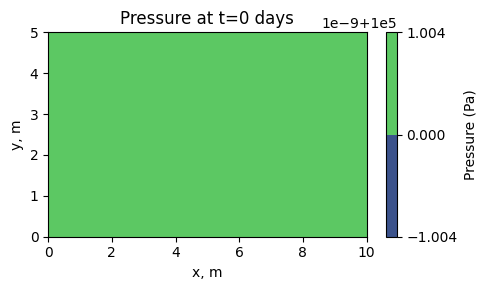

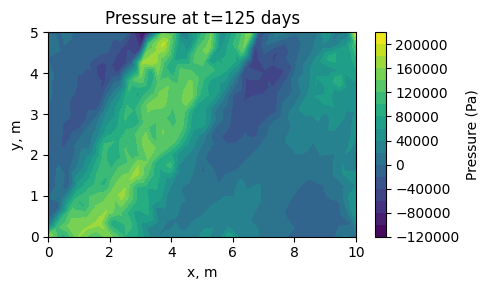

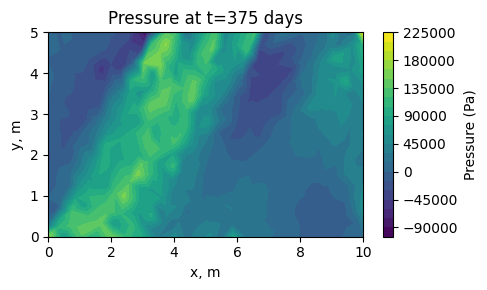

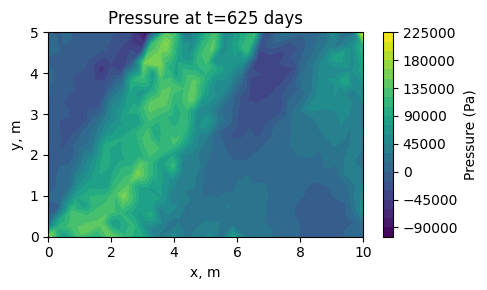

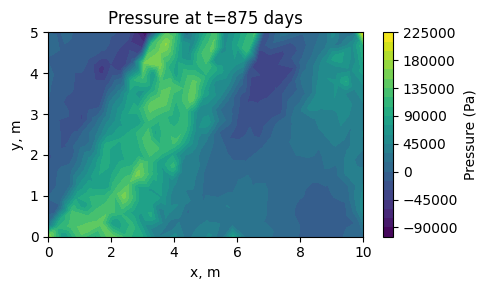

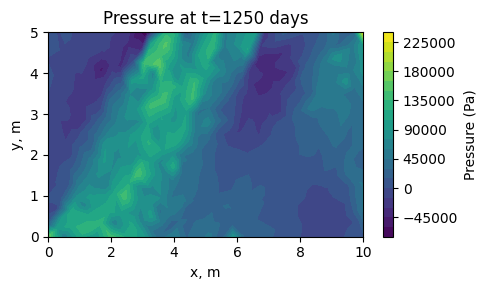

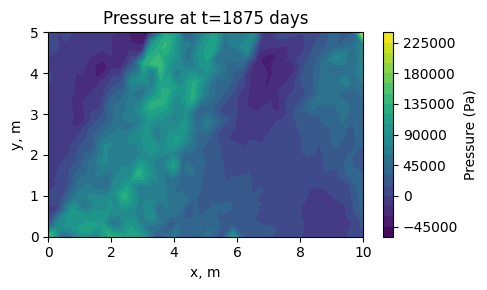

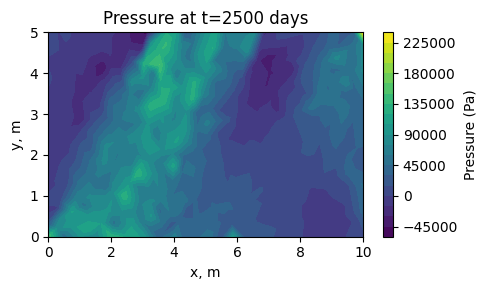

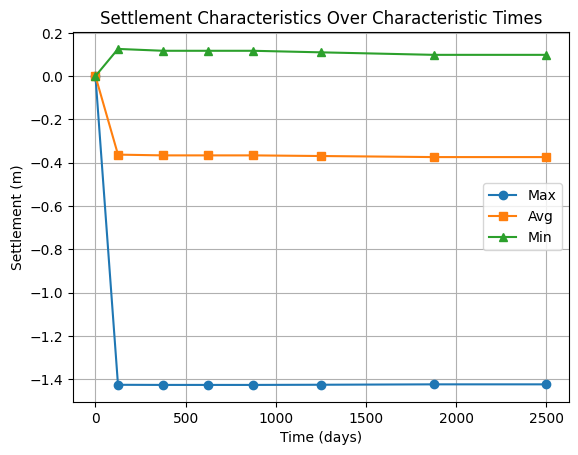

In [21]:

phi, E, nu = 0.6, 1e6, 0.3
kappa, mu = 1e-13, 1e-3
alpha, S, rho = 0.9, 5e-9, 2000
Lx, Ly = 10.0, 5.0

points   = np.array([[0,0],[Lx,0],[Lx,Ly],[0,Ly]])
segments = [[0,1],[1,2],[2,3],[3,0]]
mesh     = triangle.triangulate({'vertices': points, 'segments': segments}, 'pq30a0.1')
verts    = mesh['vertices']
tris     = mesh['triangles']
num_nodes = verts.shape[0]

lam = E * nu / ((1 + nu) * (1 - 2 * nu))
G   = E / (2 * (1 + nu))
C   = np.array([[lam + 2*G, lam,       0],
                [lam,       lam + 2*G, 0],
                [0,         0,         G]])

ndof_u = 2 * num_nodes
ndof_p = num_nodes

K = lil_matrix((ndof_u, ndof_u))
Q = lil_matrix((ndof_u, ndof_p))
H = lil_matrix((ndof_p, ndof_p))
M = lil_matrix((ndof_p, ndof_p))

for el in range(len(tris)):
    idx    = tris[el]
    coords = verts[idx]
    B, area= compute_B(coords)
    Ke     = (B.T @ C @ B) * area
    He     = (kappa / mu) * (B[:2].T @ B[:2]) * area
    Me     = S * (area / 12) * (np.ones((3,3)) + np.eye(3))
    dof_u  = np.array([[2*i,2*i+1] for i in idx]).ravel()

    for i in range(6):
        for j in range(6):
            K[dof_u[i],dof_u[j]] += Ke[i,j]
    for i in range(6):
        for j in range(3):
            Q[dof_u[i], idx[j]] += alpha * B[:,i].sum() * area/3
    for i in range(3):
        for j in range(3):
            H[idx[i],idx[j]] += He[i,j]
            M[idx[i],idx[j]] += Me[i,j]

K = K.tocsr()
Q = Q.tocsr()
H = H.tocsr()
M = M.tocsr()

bdy_u   = np.where(np.isclose(verts[:,1], 0))[0]
fixed_u = np.hstack([2*bdy_u, 2*bdy_u+1])
free_u  = np.setdiff1d(np.arange(ndof_u), fixed_u)
free_p  = np.arange(ndof_p)

top_nodes   = np.where(np.isclose(verts[:,1], Ly))[0]
red_nodes   = top_nodes[verts[top_nodes,0]  <  Lx/3]
green_nodes = top_nodes[(verts[top_nodes,0]>= Lx/3)&(verts[top_nodes,0]<2*Lx/3)]
blue_nodes  = top_nodes[verts[top_nodes,0]>=2*Lx/3]

p_prev = np.full(ndof_p, 1e5)
results_u = {0: np.zeros(ndof_u)}
results_p = {0: p_prev.copy()}

Td = (Ly**2 * S * mu) / kappa
times = [0] + [int(f*Td) for f in [0.1, 0.3, 0.5, 0.7, 1.0, 1.5, 2.0]]

pressures = {
    'red':   0.2e5,    
    'green': 2.0e5*2,  
    'blue':  1.0e5*2  
}

prev_t = 0
for t in times[1:]:
    dt = t - prev_t
    f_u = np.zeros(ndof_u)
    for n in red_nodes:   f_u[2*n+1] = -pressures['red']   * (Lx/3)/len(red_nodes)
    for n in green_nodes: f_u[2*n+1] = -pressures['green'] * (Lx/3)/len(green_nodes)
    for n in blue_nodes:  f_u[2*n+1] = -pressures['blue']  * (Lx/3)/len(blue_nodes)

    A_full = bmat([[K, -Q], [Q.T, M + dt*H]], format='csr')
    rhs    = np.hstack([f_u, M.dot(p_prev)])
    idxs   = np.hstack([free_u, ndof_u + free_p])
    sol    = spsolve(A_full[idxs][:,idxs], rhs[idxs])

    u      = np.zeros(ndof_u); u[free_u] = sol[:len(free_u)]
    p      = np.zeros(ndof_p); p[:]       = sol[len(free_u):]
    p_prev = p.copy()

    results_u[t] = u
    results_p[t] = p
    prev_t = t

for t in times:
    plt.figure(figsize=(5,3))
    plt.tricontourf(verts[:,0], verts[:,1], tris, results_p[t], levels=20)
    plt.colorbar(label='Pressure (Pa)')
    plt.title(f'Pressure at t={t} days')
    plt.xlabel('x, m'); plt.ylabel('y, m')
    plt.tight_layout()

metrics = []
for t in times:
    uy = results_u[t][1::2]
    metrics.append({
        'Time (days)': t,
        'Min Settlement (m)': float(uy.max()),
        'Avg Settlement (m)': float(uy.mean()),
        'Max Settlement (m)': float(uy.min())
    })

df = pd.DataFrame(metrics)
print(df)

plt.figure()
plt.plot(df['Time (days)'], df['Max Settlement (m)'], '-o', label='Max')
plt.plot(df['Time (days)'], df['Avg Settlement (m)'], '-s', label='Avg')
plt.plot(df['Time (days)'], df['Min Settlement (m)'], '-^', label='Min')
plt.xlabel('Time (days)')
plt.ylabel('Settlement (m)')
plt.title('Settlement Characteristics Over Characteristic Times')
plt.legend()
plt.grid(True)
plt.show()


   t(days)       min       avg       max
0        0  0.132046 -0.358589 -1.417471
1      125  0.125641 -0.362896 -1.426254
2      375  0.116917 -0.366339 -1.426750
3      625  0.116880 -0.366350 -1.426773
4      875  0.116880 -0.366350 -1.426773
5     1250  0.109714 -0.369276 -1.425940
6     1875  0.098130 -0.374184 -1.424131
7     2500  0.098100 -0.374195 -1.424113


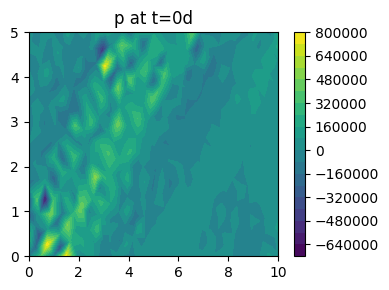

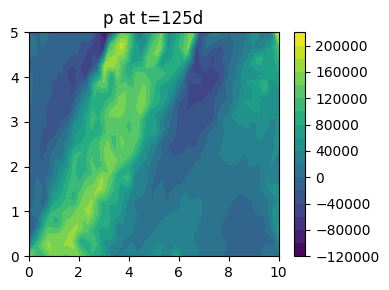

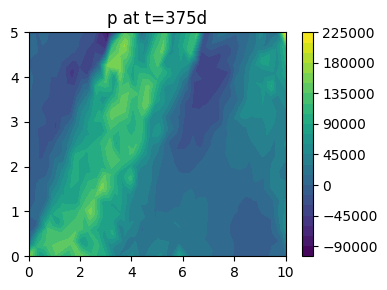

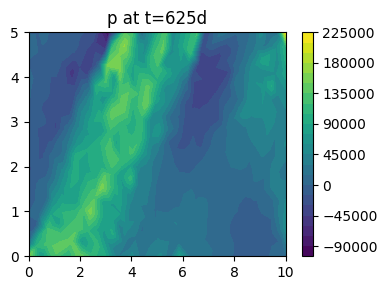

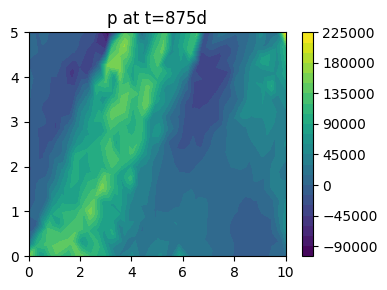

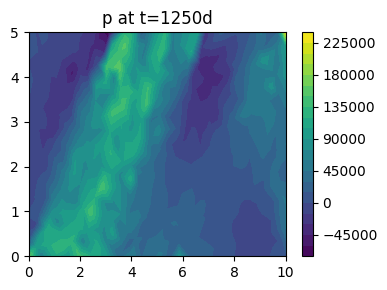

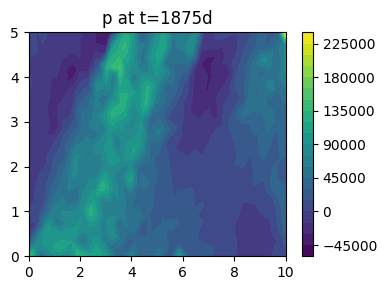

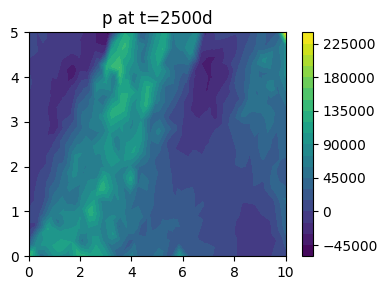

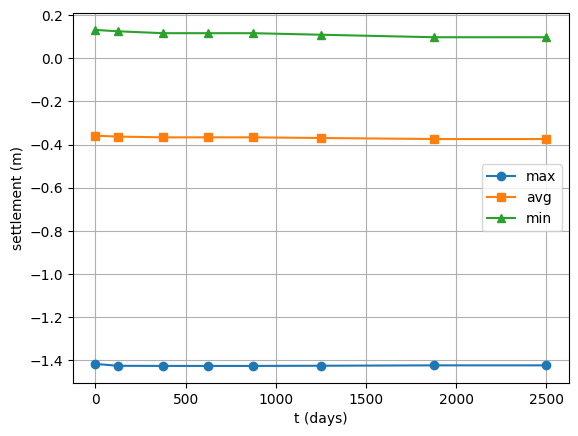

In [22]:
import numpy as np
import triangle
from scipy.sparse import lil_matrix, bmat
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
import pandas as pd

phi, E, nu = 0.6, 1e6, 0.3
kappa, mu = 1e-13, 1e-3
alpha, S, rho = 0.9, 5e-9, 2000
Lx, Ly = 10.0, 5.0

points   = np.array([[0,0],[Lx,0],[Lx,Ly],[0,Ly]])
segments = [[0,1],[1,2],[2,3],[3,0]]
mesh     = triangle.triangulate({'vertices': points, 'segments': segments}, 'pq30a0.1')
verts    = mesh['vertices']
tris     = mesh['triangles']
num_nodes = verts.shape[0]

lam = E*nu/((1+nu)*(1-2*nu))
G   = E/(2*(1+nu))
C   = np.array([[lam+2*G, lam,     0],
                [lam,     lam+2*G, 0],
                [0,       0,       G]])

ndof_u = 2*num_nodes; ndof_p = num_nodes
K = lil_matrix((ndof_u,ndof_u)); Q = lil_matrix((ndof_u,ndof_p))
H = lil_matrix((ndof_p,ndof_p)); M = lil_matrix((ndof_p,ndof_p))

for el in range(len(tris)):
    idx = tris[el]; coords = verts[idx]
    B, area = compute_B(coords)
    Ke = (B.T@C@B)*area
    He = (kappa/mu)*(B[:2].T@B[:2])*area
    Me = S*(area/12)*(np.ones((3,3))+np.eye(3))
    dof_u = np.array([[2*i,2*i+1] for i in idx]).ravel()
    for i in range(6):
        for j in range(6):
            K[dof_u[i],dof_u[j]] += Ke[i,j]
    for i in range(6):
        for j in range(3):
            Q[dof_u[i],idx[j]] += alpha*B[:,i].sum()*area/3
    for i in range(3):
        for j in range(3):
            H[idx[i],idx[j]] += He[i,j]
            M[idx[i],idx[j]] += Me[i,j]

K = K.tocsr(); Q = Q.tocsr(); H = H.tocsr(); M = M.tocsr()

bdy_u = np.where(np.isclose(verts[:,1],0))[0]
fixed_u = np.hstack([2*bdy_u,2*bdy_u+1]); free_u = np.setdiff1d(np.arange(ndof_u), fixed_u)
top_nodes = np.where(np.isclose(verts[:,1],Ly))[0]
red_nodes = top_nodes[verts[top_nodes,0]<Lx/3]
green_nodes = top_nodes[(verts[top_nodes,0]>=Lx/3)&(verts[top_nodes,0]<2*Lx/3)]
blue_nodes = top_nodes[verts[top_nodes,0]>=2*Lx/3]
free_p = np.arange(ndof_p)

Td = (Ly**2 * S * mu) / kappa  
times = [0] + [int(f*Td) for f in [0.1,0.3,0.5,0.7,1.0,1.5,2.0]]

press = {'red':0.2e5,'green':2.0e5*2,'blue':1.0e5*2}

p_prev = np.full(ndof_p,1e5)
results_u = {}; results_p = {}

prev = 0
for t in times:
    dt = t-prev
    f_u = np.zeros(ndof_u)
    for n in red_nodes:   f_u[2*n+1] = -press['red']*(Lx/3)/len(red_nodes)
    for n in green_nodes: f_u[2*n+1] = -press['green']*(Lx/3)/len(green_nodes)
    for n in blue_nodes:  f_u[2*n+1] = -press['blue']*(Lx/3)/len(blue_nodes)
    A = bmat([[K,-Q],[Q.T,M+dt*H]],format='csr')
    rhs = np.hstack([f_u, M.dot(p_prev)])
    idx = np.hstack([free_u, ndof_u+free_p])
    sol = spsolve(A[idx][:,idx],rhs[idx])
    u = np.zeros(ndof_u); u[free_u]=sol[:len(free_u)]
    p = np.zeros(ndof_p); p[:] = sol[len(free_u):]
    p_prev = p.copy()
    results_u[t]=u; results_p[t]=p
    prev = t

for t in times:
    plt.figure(figsize=(4,3))
    plt.tricontourf(verts[:,0],verts[:,1],tris,results_p[t],levels=20)
    plt.colorbar(); plt.title(f'p at t={t}d'); plt.tight_layout()

data = []
for t in times:
    uy=results_u[t][1::2]
    data.append({'t(days)':t,
                 'min':uy.max(),'avg':uy.mean(),'max':uy.min()})
df = pd.DataFrame(data)
print(df)

plt.figure()
plt.plot(df['t(days)'],df['max'],'-o',label='max')
plt.plot(df['t(days)'],df['avg'],'-s',label='avg')
plt.plot(df['t(days)'],df['min'],'-^',label='min')
plt.xlabel('t (days)');plt.ylabel('settlement (m)')
plt.legend();plt.grid();plt.show()


   Time (days)       Min       Avg       Max
0            0  0.000000 -0.200877 -0.708948
1           50  0.017682 -0.092998 -0.356103
2          100  0.017708 -0.092998 -0.356064
3          365  0.012269 -0.094655 -0.356545


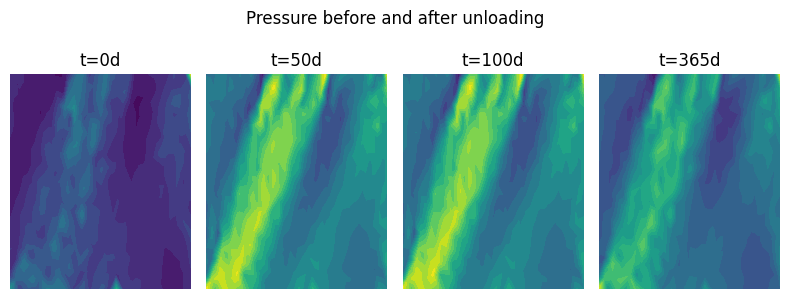

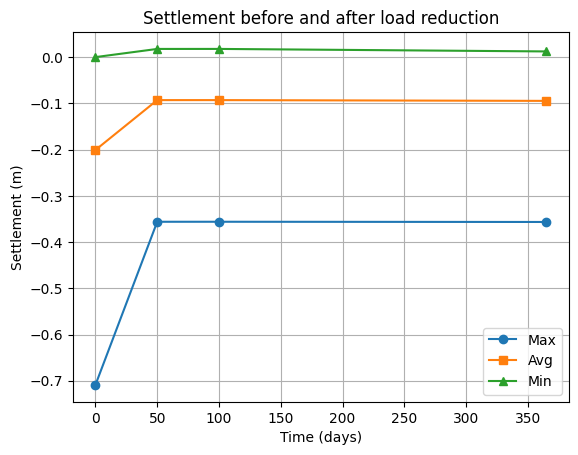

In [23]:

phi, E, nu = 0.6, 1e6, 0.3
kappa, mu = 1e-13, 1e-3
alpha, S, rho = 0.9, 5e-9, 2000
Lx, Ly = 10.0, 5.0

points   = np.array([[0,0],[Lx,0],[Lx,Ly],[0,Ly]])
segments = [[0,1],[1,2],[2,3],[3,0]]
mesh     = triangle.triangulate({'vertices': points, 'segments': segments}, 'pq30a0.1')
verts    = mesh['vertices']
tris     = mesh['triangles']
num_nodes = verts.shape[0]

lam = E*nu/((1+nu)*(1-2*nu)); G = E/(2*(1+nu))
C   = np.array([[lam+2*G, lam,     0],
                [lam,     lam+2*G, 0],
                [0,       0,       G]])

ndof_u = 2*num_nodes; ndof_p = num_nodes
K = lil_matrix((ndof_u,ndof_u)); Q = lil_matrix((ndof_u,ndof_p))
H = lil_matrix((ndof_p,ndof_p)); M = lil_matrix((ndof_p,ndof_p))
for el in range(len(tris)):
    idx, coords = tris[el], verts[tris[el]]
    B, area = compute_B(coords)
    Ke = (B.T@C@B)*area
    He = (kappa/mu)*(B[:2].T@B[:2])*area
    Me = S*(area/12)*(np.ones((3,3))+np.eye(3))
    dof_u = np.array([[2*i,2*i+1] for i in idx]).ravel()
    for i in range(6):
        for j in range(6): K[dof_u[i],dof_u[j]] += Ke[i,j]
    for i in range(6):
        for j in range(3): Q[dof_u[i], idx[j]] += alpha*B[:,i].sum()*area/3
    for i in range(3):
        for j in range(3):
            H[idx[i],idx[j]] += He[i,j]
            M[idx[i],idx[j]] += Me[i,j]
K, Q, H, M = K.tocsr(), Q.tocsr(), H.tocsr(), M.tocsr()

bdy_u = np.where(np.isclose(verts[:,1],0))[0]
fixed_u = np.hstack([2*bdy_u,2*bdy_u+1])
free_u  = np.setdiff1d(np.arange(ndof_u), fixed_u)
free_p  = np.arange(ndof_p)
top_nodes = np.where(np.isclose(verts[:,1],Ly))[0]
red_nodes   = top_nodes[verts[top_nodes,0]<Lx/3]
green_nodes = top_nodes[(verts[top_nodes,0]>=Lx/3)&(verts[top_nodes,0]<2*Lx/3)]
blue_nodes  = top_nodes[verts[top_nodes,0]>=2*Lx/3]

p_prev = np.full(ndof_p, 1e5)
press_init = {'red':0.2e5, 'green':2.0e5, 'blue':1.0e5}
dt1 = 365*5
f_u1 = np.zeros(ndof_u)
for n in red_nodes:   f_u1[2*n+1] = -press_init['red']   * (Lx/3)/len(red_nodes)
for n in green_nodes: f_u1[2*n+1] = -press_init['green'] * (Lx/3)/len(green_nodes)
for n in blue_nodes:  f_u1[2*n+1] = -press_init['blue']  * (Lx/3)/len(blue_nodes)

A1 = bmat([[K, -Q],[Q.T, M + dt1*H]], format='csr')
rhs1 = np.hstack([f_u1, M.dot(p_prev)])
idx1 = np.hstack([free_u, ndof_u+free_p])
sol1 = spsolve(A1[idx1][:,idx1], rhs1[idx1])
u1 = np.zeros(ndof_u); u1[free_u] = sol1[:len(free_u)]
p1 = np.zeros(ndof_p); p1[:] = sol1[len(free_u):]

p_prev2 = p1.copy()
press_new = {z: press_init[z]/2 for z in press_init}
times2 = [0, 50, 100, 365]
results_u = {0: u1}; results_p = {0: p1}
prev = 0
for t in times2[1:]:
    dt = t - prev
    f_u2 = np.zeros(ndof_u)
    for n in red_nodes:   f_u2[2*n+1] = -press_new['red']   * (Lx/3)/len(red_nodes)
    for n in green_nodes: f_u2[2*n+1] = -press_new['green'] * (Lx/3)/len(green_nodes)
    for n in blue_nodes:  f_u2[2*n+1] = -press_new['blue']  * (Lx/3)/len(blue_nodes)
    A2 = bmat([[K, -Q],[Q.T, M + dt*H]], format='csr')
    rhs2 = np.hstack([f_u2, M.dot(p_prev2)])
    idx2 = np.hstack([free_u, ndof_u+free_p])
    sol2 = spsolve(A2[idx2][:,idx2], rhs2[idx2])
    u2 = np.zeros(ndof_u); u2[free_u] = sol2[:len(free_u)]
    p2 = np.zeros(ndof_p); p2[:] = sol2[len(free_u):]
    results_u[t] = u2; results_p[t] = p2
    p_prev2 = p2.copy(); prev = t

plt.figure(figsize=(8,3))
for i,t in enumerate([0]+times2[1:]):
    plt.subplot(1,4,i+1)
    plt.tricontourf(verts[:,0], verts[:,1], tris, results_p[t], levels=20)
    plt.title(f't={t}d')
    plt.axis('off')
plt.suptitle('Pressure before and after unloading')
plt.tight_layout()

records = []
for t,u in results_u.items():
    uy = u[1::2]
    records.append({
        'Time (days)': t,
        'Min': uy.max(),
        'Avg': uy.mean(),
        'Max': uy.min()
    })
df = pd.DataFrame(records).sort_values('Time (days)')
print(df)

plt.figure()
plt.plot(df['Time (days)'], df['Max'], '-o', label='Max')
plt.plot(df['Time (days)'], df['Avg'], '-s', label='Avg')
plt.plot(df['Time (days)'], df['Min'], '-^', label='Min')
plt.xlabel('Time (days)')
plt.ylabel('Settlement (m)')
plt.title('Settlement before and after load reduction')
plt.legend(); plt.grid(True)
plt.show()


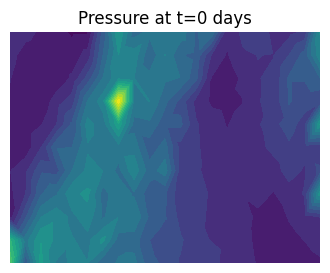

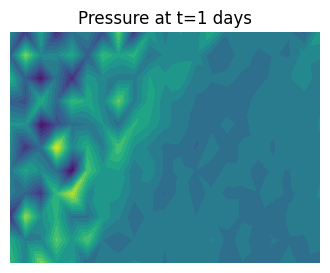

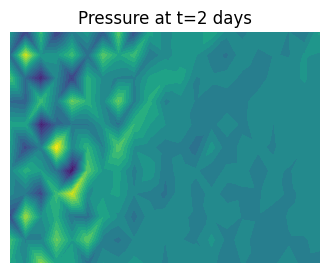

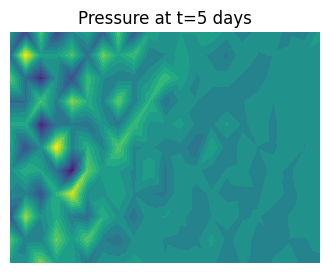

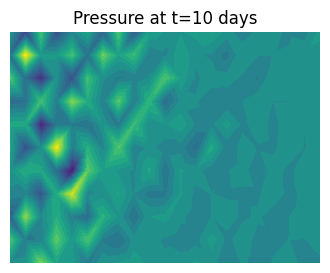

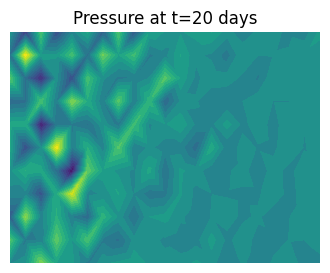

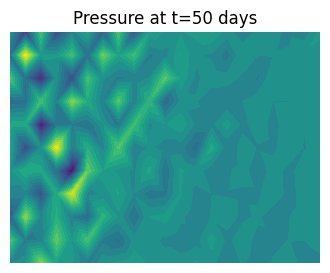

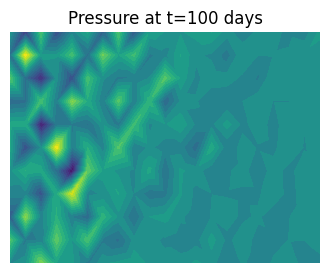

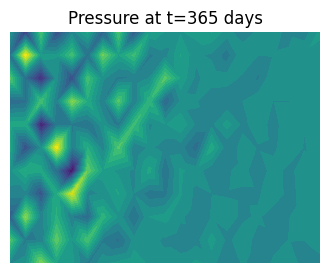

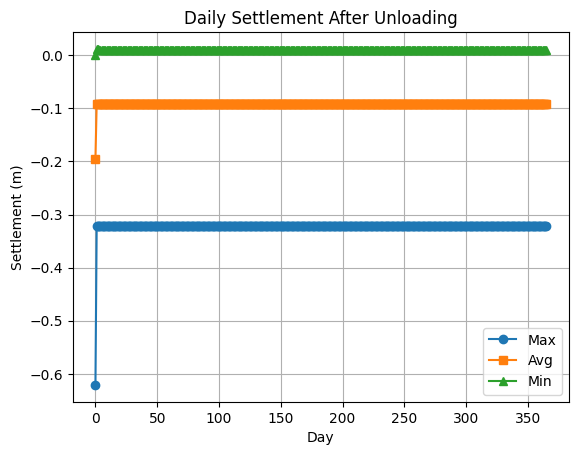

In [24]:

phi, E, nu = 0.6, 1e6, 0.3
kappa, mu = 1e-13, 1e-3
alpha, S, rho = 0.9, 5e-9, 2000
Lx, Ly = 10.0, 5.0

nx, ny = 21, 11
x = np.linspace(0, Lx, nx)
y = np.linspace(0, Ly, ny)
xx, yy = np.meshgrid(x, y)
points = np.vstack([xx.ravel(), yy.ravel()]).T
mesh = Delaunay(points)
verts = mesh.points
tris = mesh.simplices
num_nodes = len(verts)

lam = E*nu/((1+nu)*(1-2*nu))
G = E/(2*(1+nu))
C = np.array([[lam+2*G, lam, 0],
              [lam, lam+2*G, 0],
              [0, 0, G]])


ndof_u = 2*num_nodes; ndof_p = num_nodes
K = lil_matrix((ndof_u, ndof_u))
Q = lil_matrix((ndof_u, ndof_p))
H = lil_matrix((ndof_p, ndof_p))
M = lil_matrix((ndof_p, ndof_p))

for tri in tris:
    coords = verts[tri]
    B, area = compute_B(coords)
    Ke = B.T@C@B*area
    He = (kappa/mu)*(B[:2].T@B[:2])*area
    Me = S*(area/12)*(np.ones((3,3))+np.eye(3))
    dof_u = np.array([[2*i,2*i+1] for i in tri]).ravel()
    for i in range(6):
        for j in range(6):
            K[dof_u[i],dof_u[j]] += Ke[i,j]
    for i in range(6):
        for j in range(3):
            Q[dof_u[i], tri[j]] += alpha*B[:,i].sum()*area/3
    for i in range(3):
        for j in range(3):
            H[tri[i],tri[j]] += He[i,j]
            M[tri[i],tri[j]] += Me[i,j]

K, Q, H, M = K.tocsr(), Q.tocsr(), H.tocsr(), M.tocsr()

bdy_u = np.where(np.isclose(verts[:,1],0))[0]
fixed_u = np.hstack([2*bdy_u,2*bdy_u+1])
free_u = np.setdiff1d(np.arange(ndof_u), fixed_u)
free_p = np.arange(ndof_p)

top = np.where(np.isclose(verts[:,1],Ly))[0]
red = top[verts[top,0]<Lx/3]
green = top[(verts[top,0]>=Lx/3)&(verts[top,0]<2*Lx/3)]
blue = top[verts[top,0]>=2*Lx/3]

p_prev = np.full(ndof_p,1e5)
press_init = {'red':0.2e5,'green':2.0e5,'blue':1.0e5}
f_u1 = np.zeros(ndof_u)
for n in red:   f_u1[2*n+1] = -press_init['red']*(Lx/3)/len(red)
for n in green: f_u1[2*n+1] = -press_init['green']*(Lx/3)/len(green)
for n in blue:  f_u1[2*n+1] = -press_init['blue']*(Lx/3)/len(blue)
dt1 = 365*5
A1 = bmat([[K,-Q],[Q.T, M+dt1*H]],format='csr')
rhs1 = np.hstack([f_u1, M.dot(p_prev)])
idx1 = np.hstack([free_u, ndof_u+free_p])
sol1 = spsolve(A1[idx1][:,idx1], rhs1[idx1])
u1 = np.zeros(ndof_u); u1[free_u]=sol1[:len(free_u)]
p1 = np.zeros(ndof_p); p1[:] = sol1[len(free_u):]

press_new = {k:v/2 for k,v in press_init.items()}
p_prev2 = p1.copy()
days = np.arange(0,366)
results_u = {0:u1}; results_p = {0:p1}

prev = 0
for t in days[1:]:
    dt = t-prev
    f_u = np.zeros(ndof_u)
    for n in red:   f_u[2*n+1] = -press_new['red']*(Lx/3)/len(red)
    for n in green: f_u[2*n+1] = -press_new['green']*(Lx/3)/len(green)
    for n in blue:  f_u[2*n+1] = -press_new['blue']*(Lx/3)/len(blue)
    A = bmat([[K,-Q],[Q.T, M+dt*H]],format='csr')
    rhs = np.hstack([f_u, M.dot(p_prev2)])
    idx = np.hstack([free_u, ndof_u+free_p])
    sol = spsolve(A[idx][:,idx], rhs[idx])
    u = np.zeros(ndof_u); u[free_u]=sol[:len(free_u)]
    p = np.zeros(ndof_p); p[:] = sol[len(free_u):]
    p_prev2 = p.copy()
    results_u[t]=u; results_p[t]=p
    prev=t

for t in [0, 1, 2, 5, 10, 20, 50, 100, 365]:
    plt.figure(figsize=(4,3))
    plt.tricontourf(verts[:,0],verts[:,1],tris,results_p[t],levels=20)
    plt.title(f'Pressure at t={t} days')
    plt.axis('off')

records = []
for t,u in results_u.items():
    uy = u[1::2]
    records.append({'day':t,'min':uy.max(),'avg':uy.mean(),'max':uy.min()})
df = pd.DataFrame(records).sort_values('day')

plt.figure()
plt.plot(df['day'],df['max'],'-o',label='Max')
plt.plot(df['day'],df['avg'],'-s',label='Avg')
plt.plot(df['day'],df['min'],'-^',label='Min')
plt.xlabel('Day'); plt.ylabel('Settlement (m)')
plt.title('Daily Settlement After Unloading')
plt.legend(); plt.grid(); plt.show()


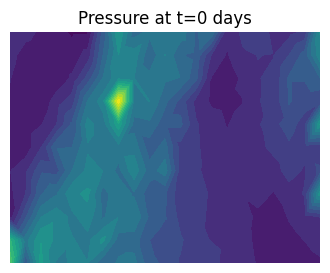

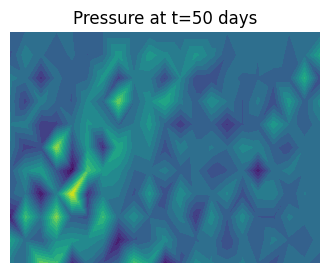

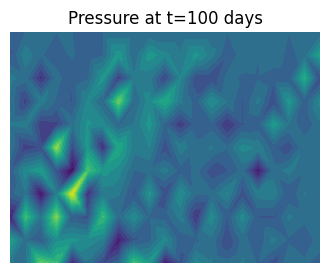

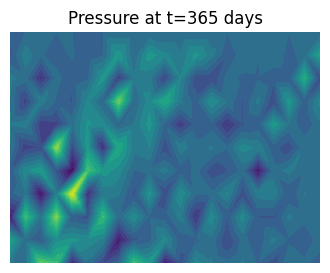

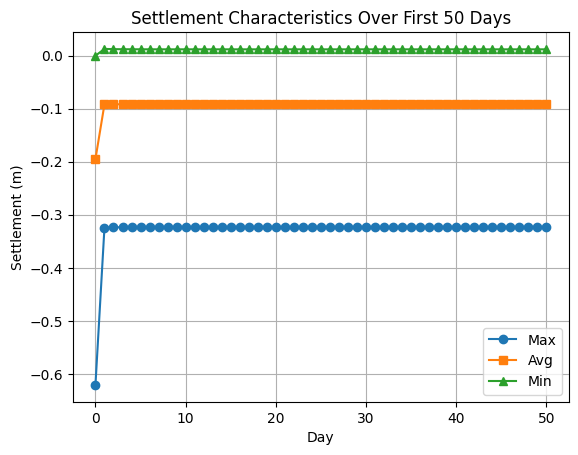

In [ ]:

phi, E, nu = 0.6, 1e6, 0.3
kappa, mu = 1e-13, 1e-3
alpha, S, rho = 0.9, 5e-9, 2000
Lx, Ly = 10.0, 5.0

nx, ny = 21, 11
x = np.linspace(0, Lx, nx)
y = np.linspace(0, Ly, ny)
xx, yy = np.meshgrid(x, y)
points = np.vstack([xx.ravel(), yy.ravel()]).T
mesh = Delaunay(points)
verts = mesh.points
tris = mesh.simplices
num_nodes = len(verts)

lam = E * nu / ((1 + nu) * (1 - 2 * nu))
G = E / (2 * (1 + nu))
C = np.array([[lam + 2*G, lam,       0],
              [lam,       lam + 2*G, 0],
              [0,         0,         G]])

ndof_u = 2 * num_nodes
ndof_p = num_nodes
K = lil_matrix((ndof_u, ndof_u))
Q = lil_matrix((ndof_u, ndof_p))
H = lil_matrix((ndof_p, ndof_p))
M = lil_matrix((ndof_p, ndof_p))

for tri in tris:
    B, area = compute_B(verts[tri])
    Ke = B.T @ C @ B * area
    He = (kappa / mu) * (B[:2].T @ B[:2]) * area
    Me = S * (area / 12) * (np.ones((3,3)) + np.eye(3))
    dof_u = np.array([[2*i,2*i+1] for i in tri]).ravel()
    for i in range(6):
        for j in range(6):
            K[dof_u[i], dof_u[j]] += Ke[i,j]
    for i in range(6):
        for j in range(3):
            Q[dof_u[i], tri[j]] += alpha * B[:,i].sum() * area/3
    for i in range(3):
        for j in range(3):
            H[tri[i], tri[j]] += He[i,j]
            M[tri[i], tri[j]] += Me[i,j]

K, Q, H, M = K.tocsr(), Q.tocsr(), H.tocsr(), M.tocsr()

bdy_u = np.where(np.isclose(verts[:,1], 0))[0]
fixed_u = np.hstack([2*bdy_u, 2*bdy_u+1])
free_u = np.setdiff1d(np.arange(ndof_u), fixed_u)

top = np.where(np.isclose(verts[:,1], Ly))[0]
red = top[verts[top,0] <  Lx/3]
green = top[(verts[top,0] >= Lx/3) & (verts[top,0] < 2*Lx/3)]
blue = top[verts[top,0] >= 2*Lx/3]

free_p_load = np.arange(ndof_p)
fixed_p_rec = top.copy()
free_p_rec = np.setdiff1d(np.arange(ndof_p), fixed_p_rec)

p_prev = np.full(ndof_p, 1e5)
press_init = {'red':0.2e5, 'green':2.0e5, 'blue':1.0e5}

f_u1 = np.zeros(ndof_u)
for n in red:   f_u1[2*n+1] = -press_init['red']   * (Lx/3)/len(red)
for n in green: f_u1[2*n+1] = -press_init['green'] * (Lx/3)/len(green)
for n in blue:  f_u1[2*n+1] = -press_init['blue']  * (Lx/3)/len(blue)

dt1 = 365 * 5
A1 = bmat([[K, -Q], [Q.T, M + dt1*H]], format='csr')
rhs1 = np.hstack([f_u1, M.dot(p_prev)])
idxs1 = np.hstack([free_u, ndof_u + free_p_load])
sol1 = spsolve(A1[idxs1][:,idxs1], rhs1[idxs1])
u1 = np.zeros(ndof_u);  u1[free_u] = sol1[:free_u.size]
p1 = np.zeros(ndof_p);  p1[:] = sol1[free_u.size:]
results_u = {0: u1}
results_p = {0: p1}

p_prev2 = p1.copy()
p_prev2[fixed_p_rec] = 0.0
press_new = {k: v/2 for k, v in press_init.items()}

days = np.arange(0, 366)
prev_t = 0
for t in days[1:]:
    dt = t - prev_t
    f_u2 = np.zeros(ndof_u)
    for n in red:   f_u2[2*n+1] = -press_new['red']   * (Lx/3)/len(red)
    for n in green: f_u2[2*n+1] = -press_new['green'] * (Lx/3)/len(green)
    for n in blue:  f_u2[2*n+1] = -press_new['blue']  * (Lx/3)/len(blue)

    A2 = bmat([[K, -Q], [Q.T, M + dt*H]], format='csr')
    rhs2 = np.hstack([f_u2, M.dot(p_prev2)])
    idxs2 = np.hstack([free_u, ndof_u + free_p_rec])
    sol2 = spsolve(A2[idxs2][:,idxs2], rhs2[idxs2])

    u2 = np.zeros(ndof_u); u2[free_u] = sol2[:free_u.size]
    p2 = np.zeros(ndof_p)
    p2[free_p_rec] = sol2[free_u.size:]
    p2[fixed_p_rec] = 0.0

    p_prev2 = p2.copy()
    results_u[t] = u2
    results_p[t] = p2
    prev_t = t

for t in [0, 50, 100, 365]:
    plt.figure(figsize=(4,3))
    plt.tricontourf(verts[:,0], verts[:,1], tris, results_p[t], levels=20)
    plt.title(f'Pressure at t={t} days')
    plt.axis('off')

records = []
for t, u in results_u.items():
    uy = u[1::2]
    records.append({'day': t, 'min': uy.max(), 'avg': uy.mean(), 'max': uy.min()})
df = pd.DataFrame(records).sort_values('day')

df50 = df[df['day'] <= 50]
plt.figure()
plt.plot(df50['day'], df50['max'], '-o', label='Max')
plt.plot(df50['day'], df50['avg'], '-s', label='Avg')
plt.plot(df50['day'], df50['min'], '-^', label='Min')
plt.xlabel('Day'); plt.ylabel('Settlement (m)')
plt.title('Settlement Characteristics Over First 50 Days')
plt.legend(); plt.grid(True)
plt.show()


  ms      Min       Avg       Max
   0 0.000000 -0.194843 -0.620908
   1 0.012604 -0.091581 -0.323872
   2 0.011981 -0.091601 -0.323272
   3 0.011631 -0.091608 -0.323021
   4 0.011400 -0.091612 -0.322876
   5 0.011228 -0.091614 -0.322784
   6 0.011088 -0.091616 -0.322722
   7 0.010968 -0.091617 -0.322679
   8 0.010861 -0.091618 -0.322648
   9 0.010762 -0.091618 -0.322623
  10 0.010670 -0.091619 -0.322602
  11 0.010583 -0.091620 -0.322584
  12 0.010500 -0.091620 -0.322566
  13 0.010420 -0.091621 -0.322550
  14 0.010343 -0.091621 -0.322533
  15 0.010269 -0.091622 -0.322516
  16 0.010196 -0.091622 -0.322499
  17 0.010125 -0.091623 -0.322481
  18 0.010056 -0.091623 -0.322464
  19 0.009989 -0.091624 -0.322446
  20 0.009922 -0.091624 -0.322428
  21 0.009857 -0.091625 -0.322410
  22 0.009793 -0.091625 -0.322391
  23 0.009731 -0.091626 -0.322373
  24 0.009669 -0.091626 -0.322355
  25 0.009608 -0.091626 -0.322337
  26 0.009548 -0.091627 -0.322318
  27 0.009488 -0.091627 -0.322300
  28 0.009430 

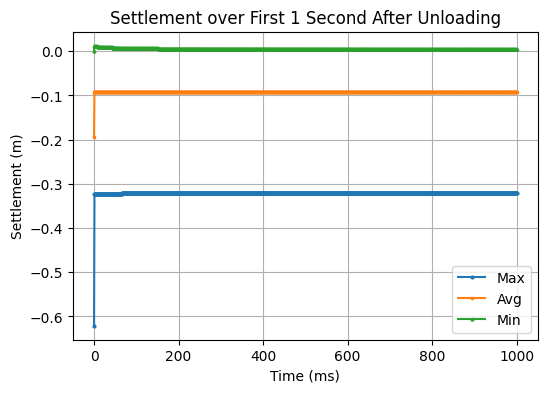

In [ ]:

phi, E, nu = 0.6, 1e6, 0.3
kappa, mu = 1e-13, 1e-3
alpha, S, rho = 0.9, 5e-9, 2000
Lx, Ly = 10.0, 5.0

nx, ny = 21, 11
x = np.linspace(0, Lx, nx)
y = np.linspace(0, Ly, ny)
xx, yy = np.meshgrid(x, y)
points = np.vstack([xx.ravel(), yy.ravel()]).T
mesh = Delaunay(points)
verts = mesh.points
tris = mesh.simplices
num_nodes = len(verts)

lam = E*nu/((1+nu)*(1-2*nu))
G   = E/(2*(1+nu))
C   = np.array([[lam+2*G, lam,     0],
                [lam,     lam+2*G, 0],
                [0,       0,       G]])


ndof_u = 2*num_nodes
ndof_p = num_nodes
K = lil_matrix((ndof_u, ndof_u))
Q = lil_matrix((ndof_u, ndof_p))
H = lil_matrix((ndof_p, ndof_p))
M = lil_matrix((ndof_p, ndof_p))

for tri in tris:
    B, area = compute_B(verts[tri])
    Ke = B.T @ C @ B * area
    He = (kappa/mu) * (B[:2].T @ B[:2]) * area
    Me = S * (area/12) * (np.ones((3,3)) + np.eye(3))
    dof_u = np.array([[2*i,2*i+1] for i in tri]).ravel()
    for i in range(6):
        for j in range(6):
            K[dof_u[i],dof_u[j]] += Ke[i,j]
    for i in range(6):
        for j in range(3):
            Q[dof_u[i], tri[j]] += alpha * B[:,i].sum() * area/3
    for i in range(3):
        for j in range(3):
            H[tri[i],tri[j]] += He[i,j]
            M[tri[i],tri[j]] += Me[i,j]

K, Q, H, M = K.tocsr(), Q.tocsr(), H.tocsr(), M.tocsr()

bdy_u   = np.where(np.isclose(verts[:,1], 0))[0]
fixed_u = np.hstack([2*bdy_u, 2*bdy_u+1])
free_u  = np.setdiff1d(np.arange(ndof_u), fixed_u)
top_nodes = np.where(np.isclose(verts[:,1], Ly))[0]
fixed_p_rec = top_nodes.copy()
free_p_rec  = np.setdiff1d(np.arange(ndof_p), fixed_p_rec)
red_nodes   = top_nodes[verts[top_nodes,0]  <  Lx/3]
green_nodes = top_nodes[(verts[top_nodes,0]>= Lx/3) & (verts[top_nodes,0]<2*Lx/3)]
blue_nodes  = top_nodes[verts[top_nodes,0]>=2*Lx/3]

u0 = results_u[0].copy()
p0 = results_p[0].copy()

press_new = {
    'red':   0.2e5/2,
    'green': 2.0e5/2,
    'blue':  1.0e5/2
}

results_u_ms = {0: u0}
results_p_ms = {0: p0}

p_prev = p0.copy()
prev_day = 0.0

times_ms = np.arange(0, 1001)
times_day = times_ms / 1000.0 / 86400.0

for ms, t_day in zip(times_ms[1:], times_day[1:]):
    dt = t_day - prev_day
    f_u = np.zeros(ndof_u)
    for n in red_nodes:
        f_u[2*n+1] = -press_new['red']   * (Lx/3)/len(red_nodes)
    for n in green_nodes:
        f_u[2*n+1] = -press_new['green'] * (Lx/3)/len(green_nodes)
    for n in blue_nodes:
        f_u[2*n+1] = -press_new['blue']  * (Lx/3)/len(blue_nodes)
    A = bmat([[K,      -Q],
              [Q.T, M + dt*H]], format='csr')
    rhs = np.hstack([f_u, M.dot(p_prev)])
    dofs = np.hstack([free_u, ndof_u + free_p_rec])
    sol = spsolve(A[dofs][:,dofs], rhs[dofs])
    u = np.zeros(ndof_u)
    u[free_u] = sol[:free_u.size]
    p = np.zeros(ndof_p)
    p[free_p_rec] = sol[free_u.size:]
    p[fixed_p_rec] = 0.0
    results_u_ms[ms] = u.copy()
    results_p_ms[ms] = p.copy()
    p_prev = p.copy()
    prev_day = t_day

records = []
for ms, u in results_u_ms.items():
    uy = u[1::2]
    records.append({
        'ms':    ms,
        'Min':  uy.max(),
        'Avg':  uy.mean(),
        'Max':  uy.min(),
    })
df_ms = pd.DataFrame(records).sort_values('ms')
print(df_ms.to_string(index=False))

plt.figure(figsize=(6,4))
plt.plot(df_ms['ms'], df_ms['Max'], '-o', markersize=2, label='Max')
plt.plot(df_ms['ms'], df_ms['Avg'], '-s', markersize=2, label='Avg')
plt.plot(df_ms['ms'], df_ms['Min'], '-^', markersize=2, label='Min')
plt.xlabel('Time (ms)')
plt.ylabel('Settlement (m)')
plt.title('Settlement over First 1 Second After Unloading')
plt.legend()
plt.grid(True)
plt.show()
